# Conditional WGAN-GP

Import Library
Mengimpor library yang dibutuhkan untuk menjalankan kode.

In [185]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable, grad
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [186]:
# Jika menggunakan cuda, pakai cuda. Jika tidak, pakai cpu.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Hyperparameter
Mendefinisikan hyperparameter yang digunakan dalam model dan pelatihan.

In [187]:
latent_dim = 100      # Dimensi ruang laten untuk generator
num_classes = 8       # Jumlah kelas bidang profesi
data_dim = 6         # Dimensi data input (jumlah fitur)
lambda_gp = 10      # Koefisien gradient penalty untuk WGAN-GP
lr_g = 0.00001       # Learning rate untuk optimizer generator
lr_d = 0.00005       # Learning rate untuk optimizer discriminator
betas = (0.5, 0.9)    # Parameter beta1 dan beta2 untuk Adam optimizer
batch_size = 64      # Ukuran batch data untuk pelatihan
num_epochs = 100   # Jumlah epoch pelatihan
patience =   20      # Jumlah epoch tanpa peningkatan untuk early stopping
min_delta = 0.001    # Minimum peningkatan loss untuk early stopping

Definisikan Generator
Mendefinisikan arsitektur generator. Generator menerima noise dan kondisi (one-hot encoding label) 
sebagai input dan menghasilkan data sintetis.

In [188]:
class ResidualBlockGen(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlockGen, self).__init__()
        self.block = nn.Sequential(
            nn.Linear(in_features, in_features),
            nn.BatchNorm1d(in_features),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(in_features, in_features),
            nn.BatchNorm1d(in_features)
        )

    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self, input_dim, condition_dim, output_dim, num_residual_blocks=3):
        super(Generator, self).__init__()
        
        self.input_layer = nn.Sequential(
            nn.Linear(input_dim + condition_dim, 256),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self.residual_blocks = nn.ModuleList([ResidualBlockGen(256) for _ in range(num_residual_blocks)])
        
        self.output_layer = nn.Sequential(
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, output_dim),
            nn.Tanh()
        )

    def forward(self, noise, condition):
        x = torch.cat([noise, condition], 1)
        x = self.input_layer(x)
        
        for residual_block in self.residual_blocks:
            x = residual_block(x)
        
        return self.output_layer(x)

Definisikan Discriminator
Mendefinisikan arsitektur discriminator. Discriminator menerima data (asli atau sintetis) dan 
kondisi sebagai input dan menghasilkan dua output: validitas (real/fake) dan prediksi kelas.

In [189]:
class ResidualBlockDiscrim(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlockDiscrim, self).__init__()
        self.block = nn.Sequential(
            nn.Linear(in_features, in_features),
            nn.LayerNorm(in_features),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(in_features, in_features),
            nn.LayerNorm(in_features)
        )

    def forward(self, x):
        return x + self.block(x)

class Discriminator(nn.Module):
    def __init__(self, input_dim, condition_dim, num_classes, num_residual_blocks=2):
        super(Discriminator, self).__init__()
        
        self.input_layer = nn.Sequential(
            nn.Linear(input_dim + condition_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3)
        )
        
        self.residual_blocks = nn.ModuleList([ResidualBlockDiscrim(512) for _ in range(num_residual_blocks)])
        
        self.shared = nn.Sequential(
            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.LayerNorm(128),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self.real_fake = nn.Sequential(
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
        
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, data, condition):
        x = torch.cat([data, condition], 1)
        x = self.input_layer(x)
        
        for residual_block in self.residual_blocks:
            x = residual_block(x)
        
        features = self.shared(x)
        validity = self.real_fake(features)
        class_pred = self.classifier(features)
        
        return validity, class_pred

Fungsi Gradient Penalty
Mendefinisikan fungsi untuk menghitung gradient penalty, yang digunakan untuk menstabilkan 
pelatihan WGAN-GP.

In [190]:
def gradient_penalty(discriminator, real_data, fake_data, condition, device):
    batch_size = real_data.size(0)
    epsilon = torch.rand(batch_size, 1, device=device).expand_as(real_data)
    interpolated = epsilon * real_data + (1 - epsilon) * fake_data
    interpolated = Variable(interpolated, requires_grad=True).to(device)

    prob_interpolated, _ = discriminator(interpolated, condition)

    gradients = grad(outputs=prob_interpolated, inputs=interpolated,
                     grad_outputs=torch.ones(prob_interpolated.size(), device=device),
                     create_graph=True, retain_graph=True)[0]

    gradients = gradients.view(batch_size, -1)
    penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return penalty


Load dan Preprocess Dataset
Fungsi untuk memuat, membersihkan, dan memproses data dari file CSV.

In [191]:
def load_and_preprocess_data(file_path):
    # Memuat data dari file CSV
    data = pd.read_csv(file_path)

    # Menampilkan beberapa baris pertama data
    print(data.head(10))

    # Menampilkan jumlah data per kelas
    print(data['PROFESI PEKERJAAN'].value_counts())

    # Mengambil fitur (bidangilmu1 - bidangilmu6) dan label (PROFESI PEKERJAAN)
    X = data[['Algoritma dan Kompleksitas, Teori Ilmu Komputer, Konsep Bahasa Pemrograman', 'Arsitektur dan organisasi komputer, jaringan dan komunikasi, sistem operasi, dan komputasi paralel dan terdistribusi', 'Sistem Cerdas', 'Pengolahan Citra, Grafik dan Multimedia', 'Keamanan Komputer', 'Ilmu Humaniora']].values.astype(float)
    y = data['PROFESI PEKERJAAN']

    # Mengubah label menjadi numerik menggunakan LabelEncoder
    le = LabelEncoder()
    y = le.fit_transform(y)
    y = torch.LongTensor(y)

    # Membuat one-hot encoding untuk kondisi (label)
    condition = torch.tensor(pd.get_dummies(data['PROFESI PEKERJAAN']).values).float()

    # Membagi data menjadi train dan test
    X_train, X_test, y_train, y_test, cond_train, cond_test = train_test_split(
        X, y, condition, test_size=0.3, random_state=42
    )

    # Mengubah data menjadi tensor PyTorch
    X_train = torch.tensor(X_train).float()
    X_test = torch.tensor(X_test).float()

    # Membuat DataLoader untuk train dan test set
    train_dataset = TensorDataset(X_train, cond_train, y_train)
    test_dataset = TensorDataset(X_test, cond_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, le

Inisialisasi Model, Optimizer, dan Loss
Menginisialisasi model Generator dan Discriminator, optimizer, dan fungsi loss.

In [192]:
def initialize_model_optimizer(latent_dim, num_classes, data_dim, lr_g, lr_d, betas, device):
    # Inisialisasi Generator dan Discriminator
    generator = Generator(latent_dim, num_classes, data_dim).to(device)
    discriminator = Discriminator(data_dim, num_classes, num_classes).to(device)

    # Inisialisasi Optimizer untuk Generator dan Discriminator
    optimizer_G = optim.Adamax(generator.parameters(), lr=lr_g, betas=betas)
    optimizer_D = optim.Adamax(discriminator.parameters(), lr=lr_d, betas=betas)

    return generator, discriminator, optimizer_G, optimizer_D

Training Loop
Melatih model Generator dan Discriminator secara bergantian.

In [193]:
def train_model(generator, discriminator, optimizer_G, optimizer_D, train_loader, num_epochs, lambda_gp, latent_dim, num_classes, patience, min_delta, device):
    best_class_loss = float('inf')
    early_stop_counter = 0

    for epoch in range(num_epochs):
        for real_data, condition, labels in train_loader:
            batch_size = real_data.size(0)

            # Move data to the device (GPU or CPU)
            real_data = real_data.to(device)
            condition = condition.to(device)
            labels = labels.to(device)

            # --- Train Discriminator ---
            for _ in range(2):  # Train discriminator more often than generator
                noise = torch.randn(batch_size, latent_dim, device=device)
                fake_data = generator(noise, condition).detach()

                d_real, class_real = discriminator(real_data, condition)
                d_fake, _ = discriminator(fake_data, condition)

                gp = gradient_penalty(discriminator, real_data, fake_data, condition, device)

                d_loss = d_fake.mean() - d_real.mean() + lambda_gp * gp
                class_loss = nn.CrossEntropyLoss()(class_real, labels)

                optimizer_D.zero_grad()
                d_loss.backward(retain_graph=True)
                class_loss.backward()
                optimizer_D.step()

            # --- Train Generator ---
            for _ in range(batch_size):
                noise = torch.randn(batch_size, latent_dim, device=device)
                condition = torch.eye(num_classes, device=device)[labels]  # Correct one-hot encoding
                fake_data = generator(noise, condition)
                g_loss = -discriminator(fake_data, condition)[0].mean()

                optimizer_G.zero_grad()
                g_loss.backward()
                optimizer_G.step()

        # Early stopping logic...
        if class_loss.item() < best_class_loss - min_delta:
            best_class_loss = class_loss.item()
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch}")
            break

        # Print loss every 10 epochs
        if epoch % 10 == 0:
            print(f"Epoch [{epoch}/{num_epochs}] | D Loss: {d_loss.item()} | G Loss: {g_loss.item()} | Class Loss: {class_loss.item()}")

    return generator, discriminator


Evaluasi
Mengevaluasi performa model dengan menghitung akurasi diskriminator dalam membedakan data real dan
fake, serta kemampuan klasifikasi diskriminator.

In [247]:
def evaluate_real_vs_fake(discriminator, generator, data_loader, latent_dim, device):
    discriminator.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for real_data, condition, _ in data_loader:
            batch_size = real_data.size(0)

            # Move data to device
            real_data = real_data.to(device)
            condition = condition.to(device)

            # Evaluate real data
            real_labels = torch.ones(batch_size, device=device)
            real_output, _ = discriminator(real_data, condition)
            real_pred = (real_output > 0.5).float().squeeze()
            y_true.extend(real_labels.tolist())
            y_pred.extend(real_pred.tolist())

            # Evaluate fake data
            noise = torch.randn(batch_size, latent_dim, device=device)
            fake_data = generator(noise, condition)
            fake_labels = torch.zeros(batch_size, device=device)
            fake_output, _ = discriminator(fake_data, condition)
            fake_pred = (fake_output > 0.5).float().squeeze()
            y_true.extend(fake_labels.tolist())
            y_pred.extend(fake_pred.tolist())

    accuracy = accuracy_score(y_true, y_pred)
    print(f"Discriminator Accuracy (Real vs Fake): {accuracy * 100:.2f}%")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred, labels=[1, 0])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Real", "Fake"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix: Real vs Fake")
    plt.xticks(rotation=45, ha="right")
    plt.show()



def evaluate_classification(discriminator, data_loader, le, device):
    discriminator.eval()  # Set the model to evaluation mode
    y_true = []
    y_pred = []

    with torch.no_grad():
        for real_data, condition, labels in data_loader:
            # Move data to the same device as the model
            real_data = real_data.to(device)
            condition = condition.to(device)
            labels = labels.to(device)

            # Forward pass through the discriminator
            _, class_output = discriminator(real_data, condition)
            
            # Get the predicted class
            class_pred = torch.argmax(class_output, dim=1)

            # Append true and predicted labels
            y_true.extend(labels.cpu().tolist())  # Move to CPU before converting to list
            y_pred.extend(class_pred.cpu().tolist())  # Move to CPU before converting to list

    # Print classification report and resize confusion matrix
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=le.classes_, zero_division=0))  # Print classification report
    

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
    # Increase the figure size
    fig, ax = plt.subplots(figsize=(10, 10))  # Adjust the size as needed
    disp.plot(ax=ax, cmap=plt.cm.Blues)
    plt.title("Confusion Matrix: Classification")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


Main Execution
Menjalankan proses pelatihan dan evaluasi model.

In [195]:
# Load dan preprocess data
train_loader, test_loader, le = load_and_preprocess_data("dataset/merged_data_cleaned_final.csv")

          ID                              PROFESI PEKERJAAN  \
0  Alumni001  INFORMATION SYSTEM AND TECHNOLOGY DEVELOPMENT   
1  Alumni002                     IT SECURITY AND COMPLIANCE   
2  Alumni003           PROGRAMMING AND SOFTWARE DEVELOPMENT   
3  Alumni004                         DATA MANAGEMENT SYSTEM   
4  Alumni005           PROGRAMMING AND SOFTWARE DEVELOPMENT   
5  Alumni006                         IT PROJECT MANAGEMENT    
6  Alumni007                         DATA MANAGEMENT SYSTEM   
7  Alumni008                     NETWORK AND INFRASTRUCTURE   
8  Alumni009                     IT SECURITY AND COMPLIANCE   
9  Alumni010                                  IT MULTEMEDIA   

   Algoritma dan Kompleksitas, Teori Ilmu Komputer, Konsep Bahasa Pemrograman  \
0                                                3.6                            
1                                                3.4                            
2                                                3.3           

In [196]:
# Inisialisasi model, optimizer with device
generator, discriminator, optimizer_G, optimizer_D = initialize_model_optimizer(latent_dim, num_classes, data_dim, lr_g, lr_d, betas, device)

In [197]:
# Move models to the correct device
generator = generator.to(device)
discriminator = discriminator.to(device)

In [198]:
# Train model
generator, discriminator = train_model(generator, discriminator, optimizer_G, optimizer_D, train_loader, num_epochs, lambda_gp, latent_dim, num_classes, patience, min_delta, device)

Epoch [0/100] | D Loss: 6.074141502380371 | G Loss: -0.42640629410743713 | Class Loss: 1.6140844821929932
Epoch [10/100] | D Loss: 0.24951711297035217 | G Loss: -0.2749202847480774 | Class Loss: 1.3840680122375488
Epoch [20/100] | D Loss: 0.5612005591392517 | G Loss: -0.15975920855998993 | Class Loss: 1.0315512418746948
Epoch [30/100] | D Loss: 0.07594972848892212 | G Loss: -0.19187061488628387 | Class Loss: 1.4351445436477661
Epoch [40/100] | D Loss: 0.40168070793151855 | G Loss: -0.16301004588603973 | Class Loss: 0.8125195503234863
Epoch [50/100] | D Loss: 0.11901742219924927 | G Loss: -0.12005923688411713 | Class Loss: 0.8620148301124573
Epoch [60/100] | D Loss: 0.047479987144470215 | G Loss: -0.11688470840454102 | Class Loss: 0.8730078339576721
Epoch [70/100] | D Loss: 0.012672007083892822 | G Loss: -0.17062903940677643 | Class Loss: 0.745060384273529
Epoch [80/100] | D Loss: -0.12814030051231384 | G Loss: -0.1366133689880371 | Class Loss: 0.38675686717033386
Epoch [90/100] | D Los


Evaluation on Training Data:
Discriminator Accuracy (Real vs Fake): 86.44%


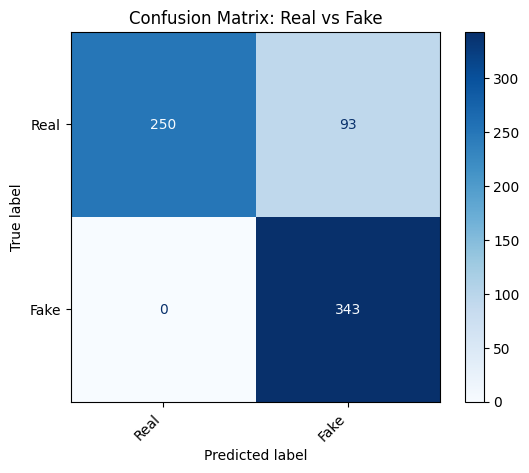

In [227]:
# Evaluation on Training Data
print("\nEvaluation on Training Data:")
evaluate_real_vs_fake(discriminator, generator, train_loader, latent_dim, device)



Evaluation on Training Data
Classification Report:
                                               precision    recall  f1-score   support

                       DATA MANAGEMENT SYSTEM       0.98      1.00      0.99        46
             HARDWARE AND DIGITAL PERIPHERALS       0.00      0.00      0.00         8
INFORMATION SYSTEM AND TECHNOLOGY DEVELOPMENT       1.00      0.29      0.44        14
                                IT MULTEMEDIA       0.55      0.95      0.70        22
                       IT PROJECT MANAGEMENT        1.00      0.57      0.73        14
                   IT SECURITY AND COMPLIANCE       0.79      1.00      0.89        58
                   NETWORK AND INFRASTRUCTURE       0.00      0.00      0.00         9
         PROGRAMMING AND SOFTWARE DEVELOPMENT       0.99      1.00      1.00       172

                                     accuracy                           0.90       343
                                    macro avg       0.67      0.60      0.59

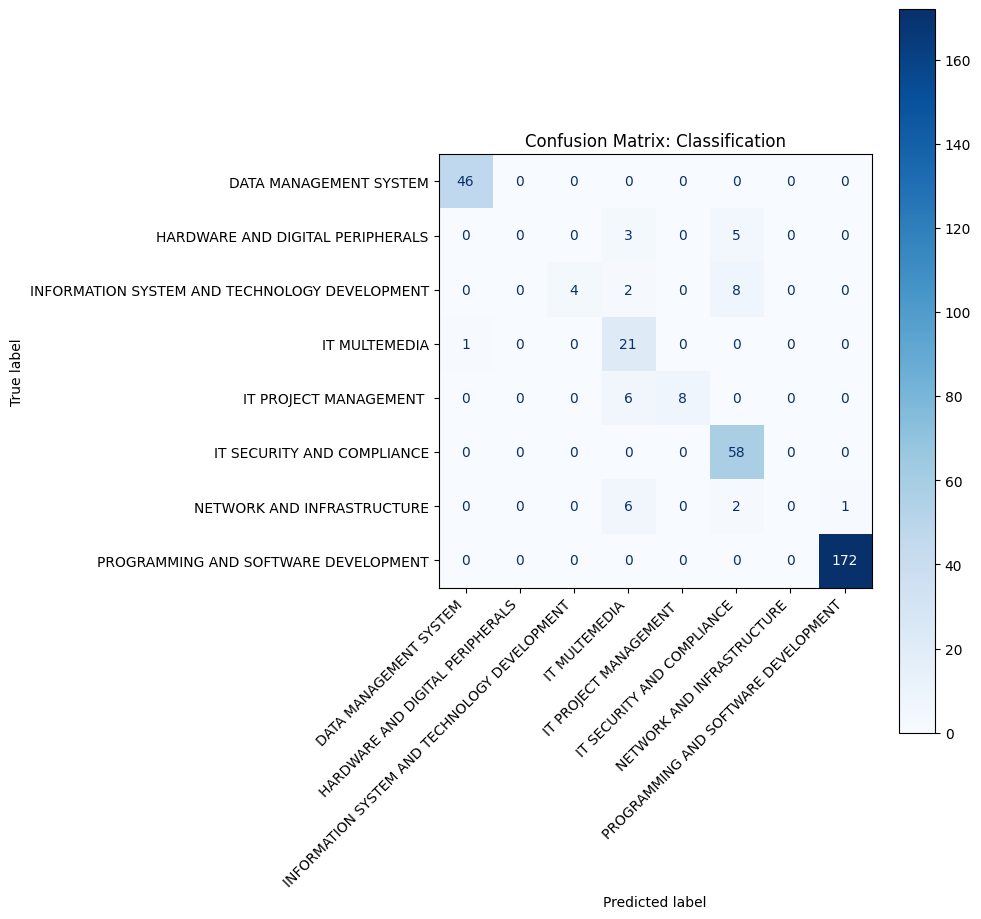

In [252]:
# Traning data
print("\nEvaluation on Training Data")
evaluate_classification(discriminator, train_loader, le, device)


Evaluation on Test Data:
Discriminator Accuracy (Real vs Fake): 87.50%


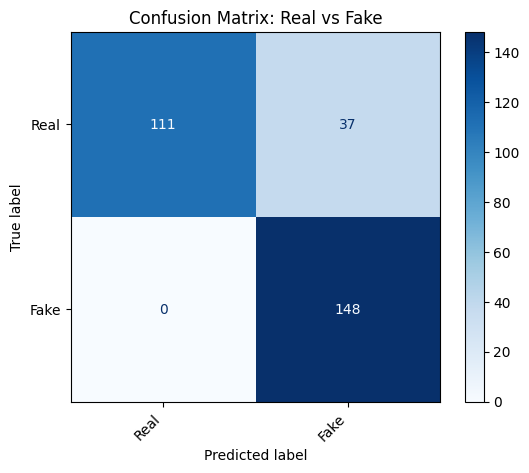

In [243]:
# Evaluation on Test Data
print("\nEvaluation on Test Data:")
evaluate_real_vs_fake(discriminator, generator, test_loader, latent_dim, device)


Evaluation on Test Data
Classification Report:
                                               precision    recall  f1-score   support

                       DATA MANAGEMENT SYSTEM       0.84      1.00      0.91        21
             HARDWARE AND DIGITAL PERIPHERALS       0.00      0.00      0.00         3
INFORMATION SYSTEM AND TECHNOLOGY DEVELOPMENT       1.00      0.55      0.71        11
                                IT MULTEMEDIA       0.71      0.91      0.80        11
                       IT PROJECT MANAGEMENT        1.00      0.14      0.25         7
                   IT SECURITY AND COMPLIANCE       0.84      1.00      0.92        27
                   NETWORK AND INFRASTRUCTURE       0.00      0.00      0.00         4
         PROGRAMMING AND SOFTWARE DEVELOPMENT       0.91      1.00      0.96        64

                                     accuracy                           0.87       148
                                    macro avg       0.66      0.57      0.57    

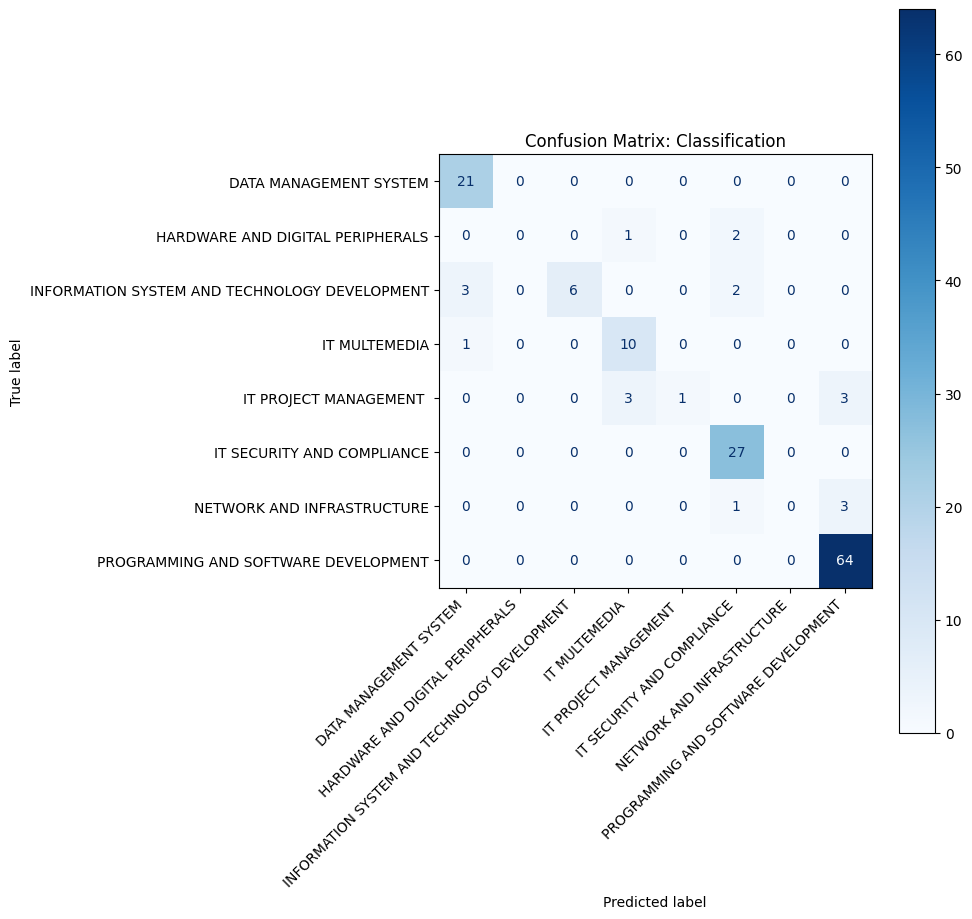

In [251]:
# Test data
print("\nEvaluation on Test Data")
evaluate_classification(discriminator, test_loader, le, device)